In [13]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import plot_roc_curve

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics.pairwise import linear_kernel
from sklearn.decomposition import NMF, PCA

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (confusion_matrix, precision_score, 
                                    recall_score, accuracy_score, r2_score, f1_score,
                                    plot_confusion_matrix, auc, roc_curve, roc_auc_score)

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, plot_confusion_matrix
from sklearn.cluster import DBSCAN

from sklearn import (
    cluster, decomposition, ensemble, manifold, 
    random_projection, preprocessing)
from sklearn.utils.class_weight import compute_class_weight

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB

# from sklearn.neighbors import KNeighborsRegressor

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import pickle
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import random

# ALL DONE WITH UNDERSAMPLING

In [14]:
df = pd.read_csv('../../../cleaned_comments.csv')

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.rating, stratify = df.rating, test_size=0.06)
y_train.value_counts()
#Rejected values utilize only 7 percent of the overall available data

len(y_test)/(len(y_test)+len(y_train))

0.06000002214451956

In [16]:
train_df = pd.concat([X_train, y_train], axis = 1)
ap_df = train_df[train_df.rating ==1]
rej_df = train_df[train_df.rating == 0]
#check your work
ap_df.rating.value_counts(), rej_df.rating.value_counts()

(1    1584507
 Name: rating, dtype: int64,
 0    113430
 Name: rating, dtype: int64)

In [17]:
#try to undersampling the majority class?
min_val = rej_df.rating.value_counts()[0]
r = np.random.RandomState(42)
inds = np.arange(min_val)
r.shuffle(inds)
rej_df1=rej_df.iloc[inds]
ap_df1=ap_df.iloc[inds]
#put indices in a random order for selection
fixed_train_df = pd.concat([rej_df1, ap_df1], axis = 0)

In [18]:
shuffled_df = fixed_train_df.sample(frac=1)

In [19]:
X_train = shuffled_df.text.values
y_train = shuffled_df.rating.values
shuffled_df.rating.value_counts()

1    113430
0    113430
Name: rating, dtype: int64

In [20]:
print(f'testing size = {len(y_test)/(len(y_train)+len(y_test))}')

testing size = 0.3232887581695447


# Original TFDIF with Random Forest

In [21]:
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english', analyzer='word', strip_accents='ascii',sublinear_tf = True)
x_train_vect = vectorizer.fit_transform(X_train)
x_test_vect = vectorizer.transform(X_test.values)


model = RandomForestClassifier(n_jobs=-1, 
                               random_state  = 1,
                               max_depth = 4, 
                               n_estimators=500, 
                              max_features = 500, 
                              min_samples_split = 2,
                              bootstrap = True,
                              min_samples_leaf = 1, class_weight = 'balanced')
model.fit(x_train_vect, y_train)

# max_depth            | 4        | [3, 2, 4]
# min_samples_split    | 2        | [2, 4]
# min_samples_leaf     | 1        | [1, 2, 4]
# bootstrap            | True     | [True, False]

RandomForestClassifier(class_weight='balanced', max_depth=4, max_features=500,
                       n_estimators=500, n_jobs=-1, random_state=1)

In [22]:
orf_y_pred = model.predict(x_test_vect)

accuracy_score(y_test, orf_y_pred ), \
    precision_score(y_test, orf_y_pred ), \
           recall_score(y_test, orf_y_pred )

(0.8955055868756863, 0.9396612492657137, 0.9489613304462176)

In [23]:
def orig_vect(X_train):
    '''
    pass in x training data to fit and transform to

    Returns:
     vectorizer, x_train vectorized
    '''
    vectorizer = TfidfVectorizer(max_features=1000, \
        stop_words='english', analyzer='word',sublinear_tf = True, ngram_range=(1,2))
    x_train_vect = vectorizer.fit_transform(X_train)
    return vectorizer, x_train_vect

vectorizer, x_train_vect = orig_vect(X_train)
x_test_vect = vectorizer.transform(X_test.values)


model2 = RandomForestClassifier(n_jobs=-1, 
                               random_state  = 1,
                               max_depth = 4, 
                               n_estimators=500, 
                              max_features = 500, 
                              min_samples_split = 2,
                              bootstrap = True,
                              min_samples_leaf = 1, class_weight = 'balanced')
model2.fit(x_train_vect, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=4, max_features=500,
                       n_estimators=500, n_jobs=-1, random_state=1)

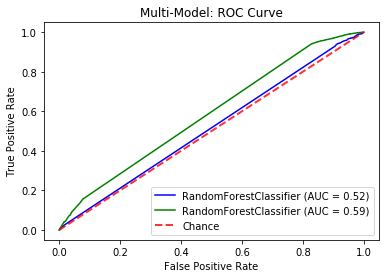

In [24]:
fig, ax = plt.subplots(1)
plot_roc_curve(model, x_test_vect, y_test, ax = ax, color = 'b')
plot_roc_curve(model2, x_test_vect, y_test, ax = ax, color = 'g')

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.legend()
plt.title('Multi-Model: ROC Curve')
plt.savefig('ROC_rf_two.png')
plt.show()

## Original TFDIF with ComplementNB

In [66]:
cnb = ComplementNB()
cnb.fit(x_train_vect, y_train)
# filename = 'balanced_cnb_model.sav'
# pickle.dump(nb, open(filename, 'wb'))


ocnb_y_pred = cnb.predict(x_test_vect)

accuracy_score(y_test, ocnb_y_pred), \
    precision_score(y_test, ocnb_y_pred), \
           recall_score(y_test, ocnb_y_pred)

(0.6511870380793328, 0.9629142364308789, 0.6513016739338929)

# Optimized TFDIF for Random Forest

In [11]:
new_vectorizer = TfidfVectorizer(analyzer='word', binary=False, decode_error='strict', encoding='utf-8',
                    input='content', lowercase=True, max_df=0.25, max_features=None,
                    min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                    smooth_idf=True, stop_words='english', strip_accents=None,
                    sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                    tokenizer=None, use_idf=True, vocabulary=None)

x_train_nvect = new_vectorizer.fit_transform(X_train)
x_test_nvect = new_vectorizer.transform(X_test.values)



rf = RandomForestClassifier(n_jobs=-1, 
                               random_state  = 1,
                               max_depth = 4, 
                               n_estimators=500, 
                              max_features = 500, 
                              min_samples_split = 2,
                              bootstrap = True,
                              min_samples_leaf = 1)
                                
rf.fit(x_train_nvect, y_train)

# max_depth            | 4        | [3, 2, 4]
# min_samples_split    | 2        | [2, 4]
# min_samples_leaf     | 1        | [1, 2, 4]
# bootstrap            | True     | [True, False]

RandomForestClassifier(max_depth=4, max_features=500, n_estimators=500,
                       n_jobs=-1, random_state=1)

In [12]:
nrfy_pred = rf.predict(x_test_nvect)

accuracy_score(y_test, nrfy_pred), \
    precision_score(y_test, nrfy_pred), \
           recall_score(y_test, nrfy_pred)

(0.48141245075152933, 0.9633334020746118, 0.46186930857532704)

# Optimized TFDIF for Complement Naive Bayes

In [68]:
new_vectorizer = TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                encoding='utf-8',
                input='content', lowercase=True, max_df=0.25, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)


x_train_nvect = new_vectorizer.fit_transform(X_train)
x_test_nvect = new_vectorizer.transform(X_test.values)


new_cnb = ComplementNB()
new_cnb.fit(x_train_nvect, y_train)
# filename = 'balanced_cnb_model.sav'
# pickle.dump(nb, open(filename, 'wb'))


ncnby_pred = new_cnb.predict(x_test_nvect)

accuracy_score(y_test, ncnby_pred), \
    precision_score(y_test, ncnby_pred), \
           recall_score(y_test, ncnby_pred)

(0.7189584698142629, 0.9704222352377403, 0.7208099743916788)

## PLOT Confusion Matrices

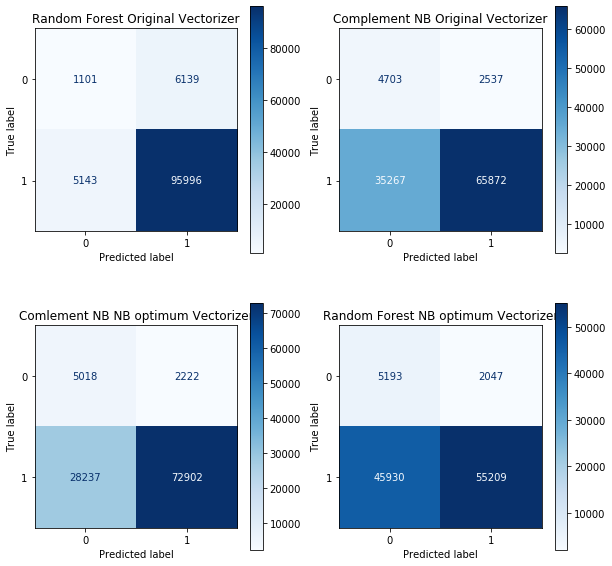

In [105]:
fig, axs = plt.subplots(2,2, figsize = (10,10))
ax = axs.flatten()
plot_confusion_matrix(model,x_test_vect, y_test, cmap = plt.cm.Blues, ax = ax[0])
ax[0].set_title('Random Forest Original Vectorizer')
plot_confusion_matrix(cnb,x_test_vect, y_test, cmap = plt.cm.Blues, ax = ax[1])
ax[1].set_title('Complement NB Original Vectorizer')

plot_confusion_matrix(new_cnb,x_test_nvect, y_test, cmap = plt.cm.Blues, ax = ax[2])
ax[2].set_title('Comlement NB NB optimum Vectorizer')
plot_confusion_matrix(rf,x_test_nvect, y_test, cmap = plt.cm.Blues, ax = ax[3])
ax[3].set_title('Random Forest NB optimum Vectorizer')
# plt.savefig('../images/nb_optimum_conmtx.png')
plt.show();


# PLOT ROC CURVES

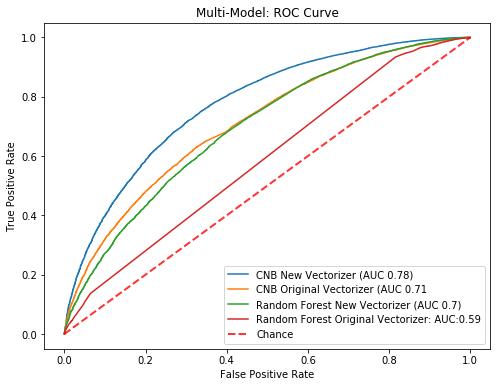

In [76]:
fig, ax = plt.subplots(1, figsize = (8,6))
plot_roc_curve(new_cnb, x_test_nvect, y_test, ax = ax, \
               label = f'CNB New Vectorizer (AUC {0.78})')


plot_roc_curve(cnb, x_test_vect, y_test, ax = ax, \
               label = f'CNB Original Vectorizer (AUC {0.71}')

plot_roc_curve(rf, x_test_nvect, y_test, ax = ax, \
               label = f'Random Forest New Vectorizer (AUC {0.70})')


plot_roc_curve(model, x_test_vect, y_test, ax = ax, \
               label = f'Random Forest Original Vectorizer: AUC:{0.59}')


ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.legend()
plt.title('Multi-Model: ROC Curve')
# plt.savefig('')
plt.show()

## PLOT APR IMPROVMENT

In [ ]:
#Random Forest Improvment
labels = ['Basic Parameters', 'class weight = balanced', 'Undersampling majority class', 'Grid search', 'Using full dataset']
accuracies = [0.48, 0.53, 0.83, 0.89, 0.89]
Precision = [0.95,0.95,0.94,0.93,0.93]
Recall = [0.47, 0.52, 0.86, 0.94, 0.95]

plt.style.use('ggplot')
plt.plot(labels,Precision, label = 'Precision')
plt.plot(labels,Recall, label = 'Recall')
plt.plot(labels,accuracies, label = 'Accuracy')
plt.xticks(rotation=30, ha = 'right')
plt.title('Score Improvments')
plt.ylabel('Scores')
plt.legend(prop={'size': 12})
plt.tight_layout()
# plt.savefig('../images/Score_improve.png')
plt.show();